In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, minmax_scale
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import sys 
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.utils import np_utils
import tensorflow as tf
#from keras.regularizers import L1L2
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.utils import shuffle
#from keras.callbacks import EarlyStopping
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from featurewiz import featurewiz
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectKBest, f_classif, chi2, RFE
from sklearn.feature_selection import mutual_info_classif
np.random.seed(19680801)

Imported version = 0.1.70.
from featurewiz import FeatureWiz
wiz = FeatureWiz(verbose=1)
X_train_selected = wiz.fit_transform(X_train, y_train)
X_test_selected = wiz.transform(X_test)
wiz.features  ### provides a list of selected features ###
                                


In [2]:
def train(x_train):
    
    
  
    y_train = x_train['class']
    
    x_train = x_train.drop(['class','cluster','year','n','pct_dusted_ccn','pct_dusted_rmcl',
                           'pct_in_secbiggest_anc','rcr_low','secbiggest_anc',
                           'pct_of_biggest_anc_newish','pct_of_biggest_anc_new','n_clusts_90_anc'
                           ,'pct_in_biggest_anc','biggest_anc','pct_of_secbiggest_anc_newish'
                           ], axis = 1)
    
    x_train[['pct_of_biggest_anc','pct_is_newish','wrcr']] = minmax_scale(x_train[[
    'pct_of_biggest_anc','pct_is_newish','wrcr']])
    
    
    '''
    x_train[['wrcr','rcr_hi','rcr_mid','n_biggest_anc','n_secbiggest_anc','n_clusts_90_anc','pct_of_biggest_anc_new']] = minmax_scale(x_train[['wrcr','rcr_hi','rcr_mid','n_biggest_anc','n_secbiggest_anc','n_clusts_90_anc','pct_of_biggest_anc_new']])
    x_train = x_train.drop(['cluster','year','n','pct_is_newish','pct_dusted_ccn','pct_dusted_rmcl','biggest_anc','pct_in_biggest_anc','pct_of_biggest_anc','pct_of_biggest_anc_new','pct_of_biggest_anc_newish','secbiggest_anc'], axis = 1)#$%
    #x_train = x_train.drop(['pct_of_biggest_anc_new','pct_of_secbiggest_anc_new','animal','pct_is_newish'], axis = 1)
    x_train = x_train.drop(['pct_in_secbiggest_anc','pct_of_secbiggest_anc','pct_of_secbiggest_anc_newish','rcr_low','cited_by_clin','class'], axis = 1)
    '''
    
    y_train = np.array(y_train)
 
    model = LogisticRegression(random_state=0, C = 10).fit(x_train,y_train) ##logistioc
    
    '''crossvalidation2(x_train, y_train)
    print(model.intercept_, model.coef_, model.score(x_train, y_train))'''
    scores = cross_val_score(model, x_train, y_train, cv=20,scoring = "f1")
    print("cv score ", scores.mean())
    return model

exem = pd.read_csv("gold_with_pivotal.csv")
exem['exemplar_year'] = exem['exemplar_year'].astype(int)
exem['exemplar_cl'] = exem['exemplar_cl'].astype(int)
#exem = exem[exem['exemplar_year'] < 2021]
prediction = []
for ind in exem.index:
    yr = int(exem['exemplar_year'][ind])
    cl = int(exem['exemplar_cl'][ind])
    
    x_train = pd.read_csv("data_84.csv")
    x_test = pd.read_csv("~/Documents/PhD/project_nobel/boty/boty_direct/features_prediction_"+str(yr)+".csv")
    x_test = x_test.dropna(axis=0)
    
    x_test = x_test[x_test['n'] > 100]
    
    print("len of xtest ",len(x_test))
       
    copy_test = x_test.copy()
    x_test = x_test.drop(['prediction','cluster','year','n',
                               'pct_in_secbiggest_anc','rcr_low','secbiggest_anc',
                               'pct_of_biggest_anc_newish','pct_of_biggest_anc_new','n_clusts_90_anc'
                               ,'pct_in_biggest_anc','biggest_anc','pct_of_secbiggest_anc_newish'
                               ], axis = 1)
    
    x_test[['pct_of_biggest_anc','pct_is_newish','wrcr']] = minmax_scale(x_test[[
    'pct_of_biggest_anc','pct_is_newish','wrcr']])
    
    
    print("hdhdhd before ",len(x_train))
    x_train = x_train[x_train['year'] != yr]
    x_train = x_train[x_train['n'] > 100]

    
    #x_train = x_train[x_train['is_research_article'] > 0.75]
    print('len of xtrain ', len(x_train))

    model = train(x_train)
    
    pred = model.predict(x_test)
    print(pred.shape)
    #print(np.sum(pred))
    print("no of positive ",np.count_nonzero(pred == 1))
    

    
    predy = model.predict_proba(x_test)
    pred_test = []
    for i in range(predy.shape[0]):
        if predy[i][0] >= predy[i][1]:
            #pred_test.append(0.00)
            pred_test.append(predy[i][1])
        else:
            pred_test.append(predy[i][1])
    
    predy = pd.DataFrame(predy, columns = ['col_0','col_1'])
    predy = predy[predy['col_1'] > 0.75]
    #print("len of df ", len(df))
    print("len of predy ", len(predy))
    copy_test['pred_log'] = pred_test
    
    a = copy_test[copy_test['cluster'] == cl]
    if len(a) == 0:
        prediction.append(-1)
        continue
    a = a.to_numpy()
    prediction.append(a[0][np.shape(a)[1] - 1])
exem['pred'] = prediction
#exem.to_csv("exemplar_prediction.csv", index = False)

len of xtest  8478
hdhdhd before  223
len of xtrain  213
cv score  0.736950271950272
(8478,)
no of positive  1037
len of predy  279
len of xtest  8478
hdhdhd before  223
len of xtrain  213
cv score  0.736950271950272
(8478,)
no of positive  1037
len of predy  279
len of xtest  8760
hdhdhd before  223
len of xtrain  211
cv score  0.7384615384615384
(8760,)
no of positive  1026
len of predy  276
len of xtest  11612
hdhdhd before  223
len of xtrain  211
cv score  0.7371664446664447
(11612,)
no of positive  1068
len of predy  277
len of xtest  11612
hdhdhd before  223
len of xtrain  211
cv score  0.7371664446664447
(11612,)
no of positive  1068
len of predy  277
len of xtest  11612
hdhdhd before  223
len of xtrain  211
cv score  0.7371664446664447
(11612,)
no of positive  1068
len of predy  277
len of xtest  11295
hdhdhd before  223
len of xtrain  213
cv score  0.7512964812964813
(11295,)
no of positive  872
len of predy  220
len of xtest  11295
hdhdhd before  223
len of xtrain  213
cv sco

len of xtest  9707
hdhdhd before  223
len of xtrain  195
cv score  0.7234704184704184
(9707,)
no of positive  909
len of predy  213
len of xtest  9707
hdhdhd before  223
len of xtrain  195
cv score  0.7234704184704184
(9707,)
no of positive  909
len of predy  213
len of xtest  9707
hdhdhd before  223
len of xtrain  195
cv score  0.7234704184704184
(9707,)
no of positive  909
len of predy  213
len of xtest  10154
hdhdhd before  223
len of xtrain  193
cv score  0.7530952380952382
(10154,)
no of positive  943
len of predy  227
len of xtest  5895
hdhdhd before  223
len of xtrain  213
cv score  0.7465750915750916
(5895,)
no of positive  1208
len of predy  468
len of xtest  6459
hdhdhd before  223
len of xtrain  213
cv score  0.7567266067266067
(6459,)
no of positive  1265
len of predy  491
len of xtest  10491
hdhdhd before  223
len of xtrain  194
cv score  0.7194769119769119
(10491,)
no of positive  1057
len of predy  250
len of xtest  10491
hdhdhd before  223
len of xtrain  194
cv score  0

cv score  0.7433291708291708
(12492,)
no of positive  1019
len of predy  296
len of xtest  12051
hdhdhd before  223
len of xtrain  207
cv score  0.7423648573648574
(12051,)
no of positive  851
len of predy  203
len of xtest  12051
hdhdhd before  223
len of xtrain  207
cv score  0.7423648573648574
(12051,)
no of positive  851
len of predy  203
len of xtest  10878
hdhdhd before  223
len of xtrain  202
cv score  0.7676745476745477
(10878,)
no of positive  1139
len of predy  306
len of xtest  10878
hdhdhd before  223
len of xtrain  202
cv score  0.7676745476745477
(10878,)
no of positive  1139
len of predy  306
len of xtest  10878
hdhdhd before  223
len of xtrain  202
cv score  0.7676745476745477
(10878,)
no of positive  1139
len of predy  306
len of xtest  10878
hdhdhd before  223
len of xtrain  202
cv score  0.7676745476745477
(10878,)
no of positive  1139
len of predy  306
len of xtest  10878
hdhdhd before  223
len of xtrain  202
cv score  0.7676745476745477
(10878,)
no of positive  113

cv score  0.7194769119769119
(10491,)
no of positive  1057
len of predy  250
len of xtest  10154
hdhdhd before  223
len of xtrain  193
cv score  0.7530952380952382
(10154,)
no of positive  943
len of predy  227
len of xtest  10154
hdhdhd before  223
len of xtrain  193
cv score  0.7530952380952382
(10154,)
no of positive  943
len of predy  227
len of xtest  10154
hdhdhd before  223
len of xtrain  193
cv score  0.7530952380952382
(10154,)
no of positive  943
len of predy  227
len of xtest  10154
hdhdhd before  223
len of xtrain  193
cv score  0.7530952380952382
(10154,)
no of positive  943
len of predy  227
len of xtest  10491
hdhdhd before  223
len of xtrain  194
cv score  0.7194769119769119
(10491,)
no of positive  1057
len of predy  250
len of xtest  10491
hdhdhd before  223
len of xtrain  194
cv score  0.7194769119769119
(10491,)
no of positive  1057
len of predy  250
len of xtest  10154
hdhdhd before  223
len of xtrain  193
cv score  0.7530952380952382
(10154,)
no of positive  943
l

cv score  0.7512964812964813
(11295,)
no of positive  872
len of predy  220
len of xtest  11295
hdhdhd before  223
len of xtrain  213
cv score  0.7512964812964813
(11295,)
no of positive  872
len of predy  220
len of xtest  9389
hdhdhd before  223
len of xtrain  203
cv score  0.7438125763125762
(9389,)
no of positive  923
len of predy  223
len of xtest  7225
hdhdhd before  223
len of xtrain  217
cv score  0.7264288489288488
(7225,)
no of positive  1166
len of predy  385
len of xtest  7225
hdhdhd before  223
len of xtrain  217
cv score  0.7264288489288488
(7225,)
no of positive  1166
len of predy  385
len of xtest  10154
hdhdhd before  223
len of xtrain  193
cv score  0.7530952380952382
(10154,)
no of positive  943
len of predy  227
len of xtest  10491
hdhdhd before  223
len of xtrain  194
cv score  0.7194769119769119
(10491,)
no of positive  1057
len of predy  250
len of xtest  10491
hdhdhd before  223
len of xtrain  194
cv score  0.7194769119769119
(10491,)
no of positive  1057
len of

cv score  0.7530952380952382
(10154,)
no of positive  943
len of predy  227
len of xtest  10154
hdhdhd before  223
len of xtrain  193
cv score  0.7530952380952382
(10154,)
no of positive  943
len of predy  227
len of xtest  10154
hdhdhd before  223
len of xtrain  193
cv score  0.7530952380952382
(10154,)
no of positive  943
len of predy  227
len of xtest  10154
hdhdhd before  223
len of xtrain  193
cv score  0.7530952380952382
(10154,)
no of positive  943
len of predy  227
len of xtest  10154
hdhdhd before  223
len of xtrain  193
cv score  0.7530952380952382
(10154,)
no of positive  943
len of predy  227
len of xtest  10154
hdhdhd before  223
len of xtrain  193
cv score  0.7530952380952382
(10154,)
no of positive  943
len of predy  227
len of xtest  10154
hdhdhd before  223
len of xtrain  193
cv score  0.7530952380952382
(10154,)
no of positive  943
len of predy  227
len of xtest  10491
hdhdhd before  223
len of xtrain  194
cv score  0.7194769119769119
(10491,)
no of positive  1057
len

cv score  0.7676745476745477
(10878,)
no of positive  1139
len of predy  306
len of xtest  10878
hdhdhd before  223
len of xtrain  202
cv score  0.7676745476745477
(10878,)
no of positive  1139
len of predy  306
len of xtest  10878
hdhdhd before  223
len of xtrain  202
cv score  0.7676745476745477
(10878,)
no of positive  1139
len of predy  306
len of xtest  10878
hdhdhd before  223
len of xtrain  202
cv score  0.7676745476745477
(10878,)
no of positive  1139
len of predy  306
len of xtest  10878
hdhdhd before  223
len of xtrain  202
cv score  0.7676745476745477
(10878,)
no of positive  1139
len of predy  306
len of xtest  10878
hdhdhd before  223
len of xtrain  202
cv score  0.7676745476745477
(10878,)
no of positive  1139
len of predy  306
len of xtest  10878
hdhdhd before  223
len of xtrain  202
cv score  0.7676745476745477
(10878,)
no of positive  1139
len of predy  306
len of xtest  10878
hdhdhd before  223
len of xtrain  202
cv score  0.7676745476745477
(10878,)
no of positive  1

385
-1  1
271
0.7057291666666666


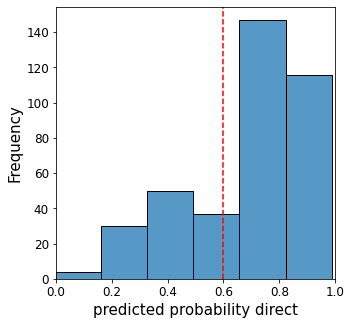

In [4]:
print(len(exem))
f = exem[exem['pred'] == -1]
print("-1 ",len(f))
d = exem[exem['pred'] > 0.60]
print(len(d))
print(len(d)/(len(exem) - len(f)))

fig = plt.figure(figsize=(5,5))
ax = sns.histplot(data = exem,x='pred', bins = 12)
plt.xlabel('predicted probability direct', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlim([0,1])
plt.axvline(x = 0.60, color = "red", ls="--")
plt.show()
fig.savefig('fig_exemplar_direct.png')